# Modeling and Analysis

We will use 10 total models for our classification problem:
1. [Logistic Regression](#Logistic-Regression)
- [Lasso Logistic Regression](#Lasso-Logistic-Regression)
- [Ridge Logistic Regression](#Ridge-Logistic-Regression)
- [Naive Bayes](#Naive-Bayes)
- [Decision Tree](#Decision-Tree)
- [Random Forest](#Random-Forest)
- [Gradient Boost](#Gradient-Boost)
- [AdaBoost](#AdaBoost)
- [Support Vector Classifier](#Support-Vector-Classifier)


and finally a [weighted ensemble model](#Voting-Ensemble) of all nine previous models.

We have chosen to diversify the application of models and include a weighted-vote ensemble because almost without exception, we see considerable overfitting issues for each base model.

Our first step will be hyperparameter selection and individual model evaluation. We will use a very limited subset of the data for hyperparameter selection due to the size of our data. Final results will use a full train/test split of all of our ~70,000 observations, but because of the large number of fits necessary during hyperparameter selection, we will only use 5% of the total data.

To further mitigate the computational cost of hyperparameter selection, we will use a random hyperparameter search instead of a grid search, which is [shown in practice](https://towardsdatascience.com/random-search-vs-grid-search-for-hyperparameter-optimization-345e1422899d) to be quicker than equivalently precise gridsearches. For all models, we will test 75 hyperparameter combinations with 5-fold cross validation, or 375 total fits.

While this is not optimal and we are likely to have some poor hyperparameters and bad fits as a result, it is a necessary limitation to impose due to time constraints and the high dimensionality of bag-of-words classification.

For all models, we will use the TfidVectorizer to prepare our data, with hyperparameters standardized based on preliminary testing for simplicity. When indicated (particularly for the Support Vector and regularized Logistic Regression models), we will use non-centered scaling (to preserve the sparsity of our word matrices) as an additional step in the model pipeline.

Selecting a wide range of models also allows us to visualize the most important features for non-black box models, important for communicating our findings.

Our objective function is raw classification accuracy. This is because our goal is simply to demonstrate that there are meaningful differences between the content of discussions on each of our three subreddits.

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from scipy.stats import uniform, loguniform
import json



pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
# Data reading 
df = pd.read_csv('../data/preprocessed_subreddit_data.csv')
df.dropna(inplace=True)

with open('../data/stop_words.json', 'r') as fp:
    stop_words = json.load(fp)
stop_words = stop_words['words']

# Full text field creation
df['fulltext'] = df['title'] + ' ' + df['selftext']

In [3]:
# Hyperparameter training sample creation
sample = df.sample(frac=.05, random_state=42)

X = sample['fulltext']
y = sample['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=42)

core_tfidf = TfidfVectorizer( max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
    stop_words=stop_words).fit(X_train)

coef_names = core_tfidf.get_feature_names()

In [4]:
# Table of Train and Test Accuracy
model_accuracy = pd.DataFrame()

### Helper Functions

In [5]:
def add_accuracy(model,title):
    model_accuracy.loc[title,'Train Accuracy'] = model.best_estimator_.score(X_train,y_train)
    model_accuracy.loc[title,'Test Accuracy'] = model.best_estimator_.score(X_test,y_test)
    model_accuracy.loc[title,'Overfittedness'] = round(model.best_estimator_.score(X_train,y_train) - model.best_estimator_.score(X_test,y_test),4)
    model_accuracy.loc[title,'Best Params'] = str(model.best_params_)

In [6]:
def confusion_matrix(model,title):
    fig, ax = plt.subplots(figsize=(8,8))
    plot_confusion_matrix(model,X_test,y_test, values_format='d', cmap='PuOr', ax=ax)
    plt.title(f'Confusion Matrix for {title}');

### Baseline Model

In [7]:
baseline_train_preds = ['asoiaf'] * len(X_train)
baseline_test_preds = ['asoiaf'] * len(X_test)

In [8]:
df['subreddit'].value_counts(normalize=True)

asoiaf           0.443182
freefolk         0.283519
gameofthrones    0.273299
Name: subreddit, dtype: float64

Our baseline accuracy if we simply guessed the most common class (asoiaf) for every prediction is 44.3%. 

### Logistic Regression

#### Fitting

In [9]:
logit_pipe = Pipeline([('tfid', TfidfVectorizer(
    max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
    stop_words=stop_words)),
    ('logit', LogisticRegression(penalty='none',
                               solver='lbfgs',
                                max_iter=1000,
                                 verbose=0
                                ))])

logit_pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('tfid',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.325,
                                 max_features=6500, min_df=5,
                                 ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['less', 'series', 'least', 'or',
                                             'with', 'sixty', 'battle', 'di...
                                 strip_accents=None, sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logit',
    

#### Evaluation

In [10]:
model_accuracy.loc['LogisticRegression','Train Accuracy'] = logit_pipe.score(X_train,y_train)

model_accuracy.loc['LogisticRegression','Test Accuracy'] = logit_pipe.score(X_test,y_test)

model_accuracy.loc['LogisticRegression','Overfittedness'] = round(logit_pipe.score(X_train,y_train) - logit_pipe.score(X_test,y_test),4)

In [11]:
model_accuracy

,Train Accuracy,Test Accuracy,Overfittedness
LogisticRegression,1.0,0.574011,0.426


We see that unregularized Logistic Regression is highly overfit. Without meaningful hyperparameters to tune, our only recourse here would be to reduce the number of features in our data manually. We will have to explore some more options.

This result is expected. Without many meaningful hyperparameters available to tune or any regularization, this dataset is problematic for a basic logistic regression.

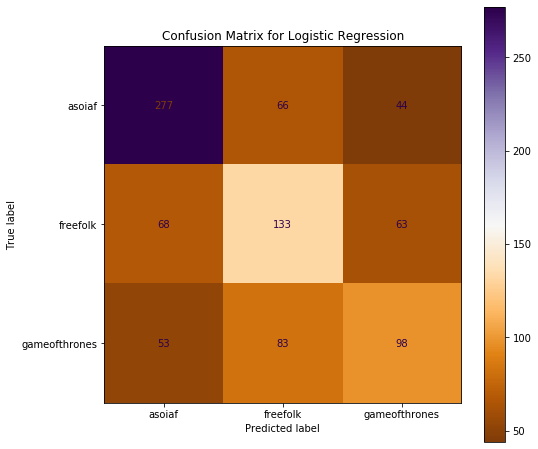

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(logit_pipe,X_test,y_test, values_format='d', cmap='PuOr', ax=ax)
plt.title('Confusion Matrix for Logistic Regression');

We see that our logistic regression is more likely to confuse r/freefolk and r/gameofthrones with each other than either with r/asoiaf. This is expected given our EDA, which showed a much larger space of words which are particularly common to r/asoiaf, but not to the other two subreddits.

### Lasso Logistic Regression

#### Fitting

In [13]:
lasso_pipe = Pipeline([('tfid', TfidfVectorizer(
    max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
    stop_words=stop_words)),
    ('ss', StandardScaler(with_mean=False)),
    ('lasso', LogisticRegression(penalty='l1',
                                 solver='liblinear'
                                 ))])

lasso_params = {
    'lasso__C': loguniform(1.0000001,20)
}

In [14]:
lasso_rs = RandomizedSearchCV(lasso_pipe,
                             lasso_params,
                             n_iter=75,
                             cv=5,
                             n_jobs=-1,
                             verbose=True,
                             random_state=42)

lasso_rs.fit(X_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  2.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tfid',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.325,
                                                              max_features=6500,
                                                              min_df=5,
                                                      

#### Evaluation

In [15]:
add_accuracy(lasso_rs,'LassoLogisticRegression')
model_accuracy

,Train Accuracy,Test Accuracy,Overfittedness,Best Params
LogisticRegression,1.0,0.574011,0.4260,NaN
LassoLogisticRegression,1.0,0.545763,0.4542,{'lasso__C': 1.0636067554253128}


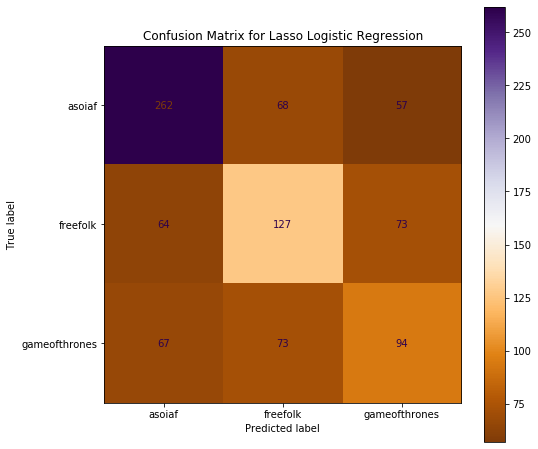

In [16]:
confusion_matrix(lasso_rs.best_estimator_,'Lasso Logistic Regression')

Overall, our test accuracy improved with regularization by about 3%, in exchange for about 8% higher bias. Given that we were starting with an unregularized model with 0% bias (100% training accuracy), we are fine with a high ratio of bias loss to variance loss in this context.

In the confusion matrix, we can again see a tendency to confuse r/freefolk and r/gameofthrones. The Lasso Logistic Regression was even more accurate in identifying r/asoiaf posts, but had a particular problem with overpredicting r/freefolk posts as r/gameofthrones posts, disproportionately so compared to the unregularized Logistic Regression.

### Ridge Logistic Regression

#### Fitting

In [17]:
ridge_pipe = Pipeline([('tfid', TfidfVectorizer(
    max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
    stop_words=stop_words)),
    ('ss', StandardScaler(with_mean=False)),
    ('ridge', LogisticRegression(penalty='l2',
                                 solver='liblinear'
                                 ))])

ridge_params = {
    'ridge__C': loguniform(1.0000001,20)
}

In [18]:
ridge_rs = RandomizedSearchCV(ridge_pipe,
                             ridge_params,
                             n_iter=75,
                             cv=5,
                             n_jobs=-1,
                             verbose=True,
                             random_state = 42)

ridge_rs.fit(X_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  2.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tfid',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.325,
                                                              max_features=6500,
                                                              min_df=5,
                                                      

#### Evaluation

In [19]:
add_accuracy(ridge_rs,'RidgeLogisticRegression')
model_accuracy

,Train Accuracy,Test Accuracy,Overfittedness,Best Params
LogisticRegression,1.0,0.574011,0.4260,NaN
LassoLogisticRegression,1.0,0.545763,0.4542,{'lasso__C': 1.0636067554253128}
RidgeLogisticRegression,1.0,0.522034,0.4780,{'ridge__C': 6.009974959585542}


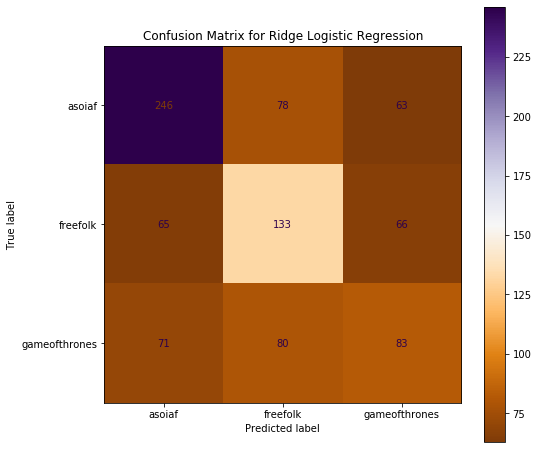

In [20]:
confusion_matrix(ridge_rs.best_estimator_,'Ridge Logistic Regression')

Our Ridge Logistic Regressor showed considerably worse performance across the board than even our Unregularized Logistic Regression. RLR notably overpredicted incidences of r/asoiaf. It's not clear why Lasso would outperform Ridge so drastically, and it's possible that our random sampling process was simply unable to find a particularly good regularization coefficient. 

We suspect this especially because our Ridge and Lasso Logistic Regressions both chose the same best value of C. This isn't due to a coding error, simply their random_state and C search space being identical, but one would expect the different loss functions to have more substantially different local minima. Insufficient time for hyperparameter tuning given the scale of our data seems to be the core issue either way.

### Naive Bayes

#### Fitting

In [21]:
nb_pipe = Pipeline([('tfid', TfidfVectorizer(
    max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
    stop_words=stop_words)),
    ('nb', MultinomialNB())])

nb_params = {
    'nb__alpha': loguniform(1.0000001,20)
}

In [22]:
nb_rs = RandomizedSearchCV(nb_pipe,
                             nb_params,
                             n_iter=75,
                             cv=5,
                             n_jobs=-1,
                             verbose=True,
                             random_state = 42)

nb_rs.fit(X_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  2.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tfid',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.325,
                                                              max_features=6500,
                                                              min_df=5,
                                                      

#### Evaluation

In [23]:
add_accuracy(nb_rs,'MultinomialNaiveBayes')
model_accuracy

,Train Accuracy,Test Accuracy,Overfittedness,Best Params
LogisticRegression,1.000000,0.574011,0.4260,NaN
LassoLogisticRegression,1.000000,0.545763,0.4542,{'lasso__C': 1.0636067554253128}
RidgeLogisticRegression,1.000000,0.522034,0.4780,{'ridge__C': 6.009974959585542}
MultinomialNaiveBayes,0.753394,0.576271,0.1771,{'nb__alpha': 1.0166804751089014}


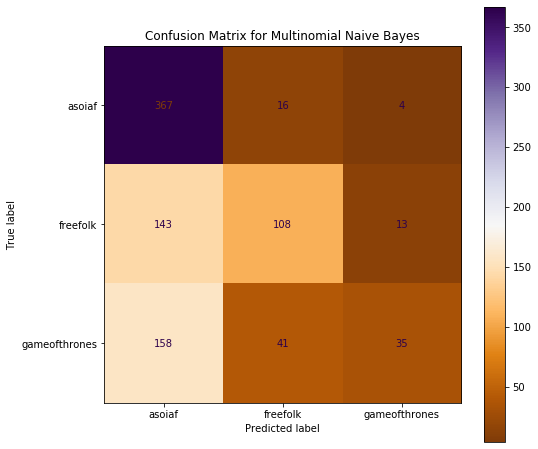

In [24]:
confusion_matrix(nb_rs.best_estimator_,'Multinomial Naive Bayes')

The Naive Bayes classifier also seems to have suffered from hyperparameter search issues, failing to reach a good alpha.  

### Decision Tree

In [25]:
dt_pipe = Pipeline([('tfid', TfidfVectorizer(
    max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
    stop_words=stop_words)),
    ('dt', DecisionTreeClassifier())])

dt_params = {
    'dt__max_depth': uniform(1,100),
    'dt__min_samples_split': uniform(0,1),
    'dt__min_samples_leaf': uniform(0,1)
}

In [26]:
dt_rs = RandomizedSearchCV(dt_pipe,
                             dt_params,
                             n_iter=75,
                             cv=5,
                             n_jobs=-1,
                             verbose=True,
                             random_state = 42)

dt_rs.fit(X_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  2.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tfid',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.325,
                                                              max_features=6500,
                                                              min_df=5,
                                                      

#### Evaluation

In [27]:
add_accuracy(dt_rs,'DecisionTree')
model_accuracy

,Train Accuracy,Test Accuracy,Overfittedness,Best Params
LogisticRegression,1.000000,0.574011,0.4260,NaN
LassoLogisticRegression,1.000000,0.545763,0.4542,{'lasso__C': 1.0636067554253128}
RidgeLogisticRegression,1.000000,0.522034,0.4780,{'ridge__C': 6.009974959585542}
MultinomialNaiveBayes,0.753394,0.576271,0.1771,{'nb__alpha': 1.0166804751089014}
DecisionTree,0.663650,0.540113,0.1235,"{'dt__max_depth': 67.35017691080559, 'dt__min_..."


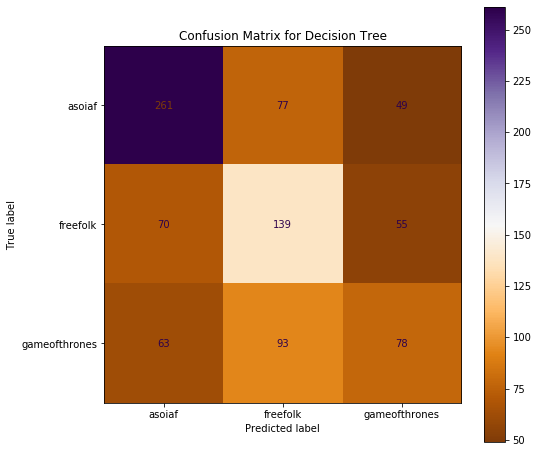

In [28]:
confusion_matrix(dt_rs.best_estimator_,'Decision Tree')

Our Decision Tree model had the best performance thusfar, showing far less overfitting than the previous four models at a perfectly reasonable bias tradeoff. In particular, it was incredibly successful at avoiding false predictions of r/asoiaf, though it resultantly overpredicted r/freefolk and r/gameofthrones. All in all, however, we're quite satisfied with this performance. That being said, it's worth continuing to an additional layer of complexity in our tree models to see if we can push performance even higher.

### Random Forest

#### Fitting

In [29]:
rf_pipe = Pipeline([('tfid', TfidfVectorizer(
    max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
    stop_words=stop_words)),
    ('rf', RandomForestClassifier())])

rf_params = {
    'rf__max_depth': uniform(1,100),
    'rf__max_features': ['auto','sqrt'],
    'rf__min_samples_split': uniform(0,1),
    'rf__min_samples_leaf': uniform(0,1),
    'rf__n_estimators': [10,50,100,500]
}

In [30]:
rf_rs = RandomizedSearchCV(rf_pipe,
                             rf_params,
                             n_iter=75,
                             cv=5,
                             n_jobs=-1,
                             verbose=True,
                             random_state = 42)

rf_rs.fit(X_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  2.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tfid',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.325,
                                                              max_features=6500,
                                                              min_df=5,
                                                      

#### Evaluation

In [31]:
add_accuracy(rf_rs,'RandomForest')
model_accuracy

,Train Accuracy,Test Accuracy,Overfittedness,Best Params
LogisticRegression,1.000000,0.574011,0.4260,NaN
LassoLogisticRegression,1.000000,0.545763,0.4542,{'lasso__C': 1.0636067554253128}
RidgeLogisticRegression,1.000000,0.522034,0.4780,{'ridge__C': 6.009974959585542}
MultinomialNaiveBayes,0.753394,0.576271,0.1771,{'nb__alpha': 1.0166804751089014}
DecisionTree,0.663650,0.540113,0.1235,"{'dt__max_depth': 67.35017691080559, 'dt__min_..."
RandomForest,0.596154,0.536723,0.0594,"{'rf__max_depth': 31.42422429595377, 'rf__max_..."


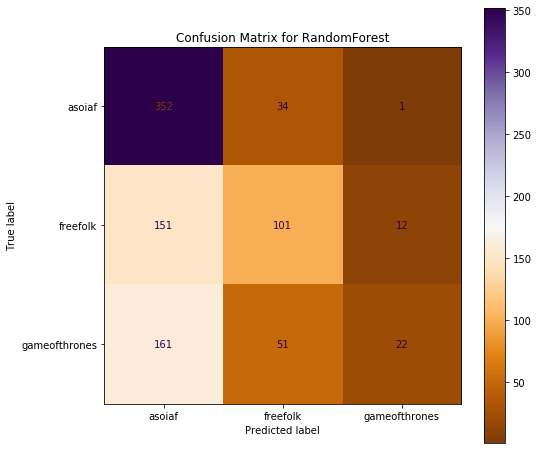

In [32]:
confusion_matrix(rf_rs.best_estimator_,'RandomForest')

The Random Forest model had similarly low overfitting compared to the Decision Tree, but much worse bias—about 10% lower accuracy on both training and testing. Interestingly, it inverted the pattern of the Decision Tree, over- instead of under-predicting r/asoiaf. 

Given the increased complexity of the model compared to the Decision Tree, it seems that we required a deeper hyperparameter search to achieve good results. This is becoming a bit of a theme.

### Gradient Boost

#### Fitting

For Gradient Boost, due to its very large space of hyperparameters to search, we will make an exception to the standard of 75 iterations * 5-fold cross validation and increase the number of iterations to 150.

In [33]:
gb_pipe = Pipeline([('tfid', TfidfVectorizer(
    max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
    stop_words=stop_words)),
    ('gb', GradientBoostingClassifier())])

gb_params = {
    'gb__learning_rate': uniform(.0001, 50),
    'gb__n_estimators':[10,50,100,500],
    'gb__subsample':uniform(.1,1),
    'gb__min_samples_split':uniform(0,.5),
    'gb__min_samples_leaf':uniform(0,.5),
    'gb__max_depth':uniform(2,100),
    'gb__max_features':['auto','sqrt','log2',uniform(0,1)]
}

In [34]:
gb_rs = RandomizedSearchCV(gb_pipe,
                             gb_params,
                             n_iter=150,
                             cv=5,
                             n_jobs=-1,
                             verbose=True,
                             random_state = 42)

gb_rs.fit(X_train,y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  9.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tfid',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.325,
                                                              max_features=6500,
                                                              min_df=5,
                                                      

#### Evaluation

In [35]:
add_accuracy(gb_rs,'Gradient Boost')
model_accuracy

,Train Accuracy,Test Accuracy,Overfittedness,Best Params
LogisticRegression,1.000000,0.574011,0.4260,NaN
LassoLogisticRegression,1.000000,0.545763,0.4542,{'lasso__C': 1.0636067554253128}
RidgeLogisticRegression,1.000000,0.522034,0.4780,{'ridge__C': 6.009974959585542}
MultinomialNaiveBayes,0.753394,0.576271,0.1771,{'nb__alpha': 1.0166804751089014}
DecisionTree,0.663650,0.540113,0.1235,"{'dt__max_depth': 67.35017691080559, 'dt__min_..."
RandomForest,0.596154,0.536723,0.0594,"{'rf__max_depth': 31.42422429595377, 'rf__max_..."
Gradient Boost,0.436652,0.437288,-0.0006,"{'gb__learning_rate': 0.27620585618011995, 'gb..."


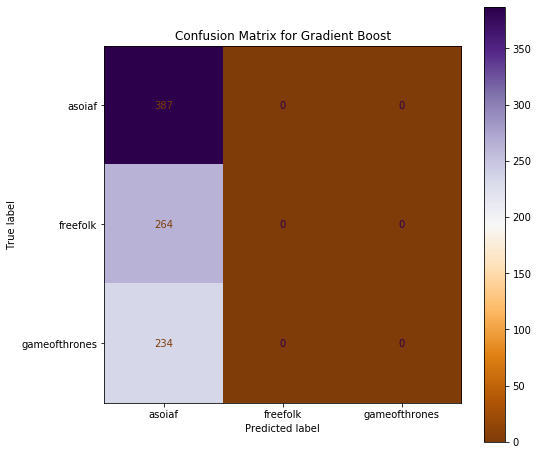

In [36]:
confusion_matrix(gb_rs.best_estimator_,'Gradient Boost')

Despite recognizing that the Gradient Boosting Classifier's required search space was much higher than our previous models and accordingly giving it substantially more hyperparameter sample trials, this model performed egregiously poorly, worse than our Baseline Model by over 20%.

While we could squeeze out an almost-reasonable accuracy rate here by altering how we interpret the model's predictions (specifically, diverting all classifications of r/freefolk to r/asoiaf), it's more headache than it's worth.

Ultimately, it seems clear that we flew too close to the sun with our attempts to use more complex tree-based models on these data. Short of renting computing time for a massive hyperparameter search, or abandoning all hope of using this computer for a day or so, we're not likely to beat the Decision Tree at this point.

The other strong option here would be to dramatically scale back the number of features we are allowing our vectorizer to produce. We may have set the hyperparameters of our vectorizer a bit prematurely, but it was the only feasible way we could test so many models. This is perhaps a lesson: less can be more.

### AdaBoost

#### Fitting

In [37]:
ab_pipe = Pipeline([('tfid', TfidfVectorizer(
    max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
    stop_words=stop_words)),
    ('ab', AdaBoostClassifier())])

ab_params = {
    'ab__n_estimators': [10,50,100,500],
    'ab__learning_rate': loguniform(.00001, 50),
}

In [38]:
ab_rs = RandomizedSearchCV(ab_pipe,
                             ab_params,
                             n_iter=75,
                             cv=5,
                             n_jobs=-1,
                             verbose=True,
                             random_state = 42)

ab_rs.fit(X_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  6.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tfid',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.325,
                                                              max_features=6500,
                                                              min_df=5,
                                                      

#### Evaluation

In [39]:
add_accuracy(ab_rs,'AdaBoost')
model_accuracy

,Train Accuracy,Test Accuracy,Overfittedness,Best Params
LogisticRegression,1.000000,0.574011,0.4260,NaN
LassoLogisticRegression,1.000000,0.545763,0.4542,{'lasso__C': 1.0636067554253128}
RidgeLogisticRegression,1.000000,0.522034,0.4780,{'ridge__C': 6.009974959585542}
MultinomialNaiveBayes,0.753394,0.576271,0.1771,{'nb__alpha': 1.0166804751089014}
DecisionTree,0.663650,0.540113,0.1235,"{'dt__max_depth': 67.35017691080559, 'dt__min_..."
RandomForest,0.596154,0.536723,0.0594,"{'rf__max_depth': 31.42422429595377, 'rf__max_..."
Gradient Boost,0.436652,0.437288,-0.0006,"{'gb__learning_rate': 0.27620585618011995, 'gb..."
AdaBoost,0.689668,0.577401,0.1123,"{'ab__learning_rate': 0.0412459590679447, 'ab_..."


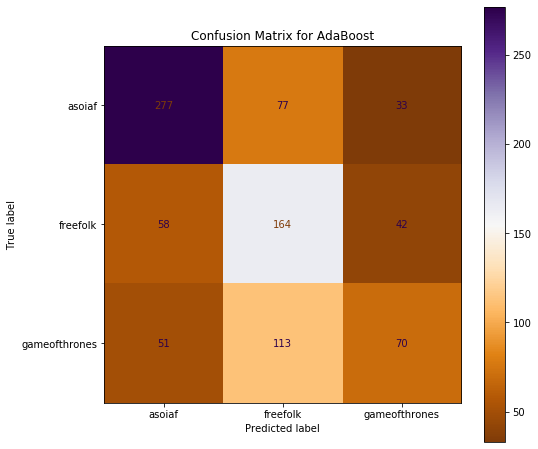

In [40]:
confusion_matrix(ab_rs.best_estimator_,'AdaBoost')

### Support Vector Classifier

#### Fitting

In [41]:
svc_pipe = Pipeline([('tfid', TfidfVectorizer(
    max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
    stop_words=stop_words)),
                  ('ss',StandardScaler(with_mean=False)),   
    ('svc', SVC())])

svc_params = {
    'svc__C': loguniform(.00001, 50),
    'svc__gamma': ['scale','auto']
}

In [42]:
svc_rs = RandomizedSearchCV(svc_pipe,
                             svc_params,
                             n_iter=75,
                             cv=5,
                             n_jobs=-1,
                             verbose=True,
                             random_state = 42)

svc_rs.fit(X_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  5.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tfid',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.325,
                                                              max_features=6500,
                                                              min_df=5,
                                                      

#### Evaluation

In [43]:
add_accuracy(svc_rs,'SupportVectorMachine')
model_accuracy

,Train Accuracy,Test Accuracy,Overfittedness,Best Params
LogisticRegression,1.000000,0.574011,0.4260,NaN
LassoLogisticRegression,1.000000,0.545763,0.4542,{'lasso__C': 1.0636067554253128}
RidgeLogisticRegression,1.000000,0.522034,0.4780,{'ridge__C': 6.009974959585542}
MultinomialNaiveBayes,0.753394,0.576271,0.1771,{'nb__alpha': 1.0166804751089014}
DecisionTree,0.663650,0.540113,0.1235,"{'dt__max_depth': 67.35017691080559, 'dt__min_..."
RandomForest,0.596154,0.536723,0.0594,"{'rf__max_depth': 31.42422429595377, 'rf__max_..."
Gradient Boost,0.436652,0.437288,-0.0006,"{'gb__learning_rate': 0.27620585618011995, 'gb..."
AdaBoost,0.689668,0.577401,0.1123,"{'ab__learning_rate': 0.0412459590679447, 'ab_..."
SupportVectorMachine,0.990573,0.552542,0.4380,"{'svc__C': 1.5580863867032468, 'svc__gamma': '..."


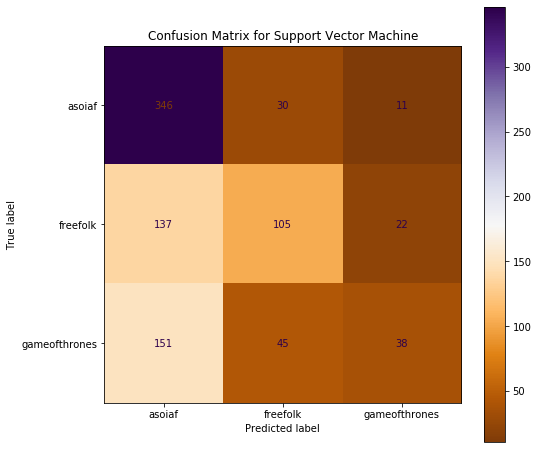

In [44]:
confusion_matrix(svc_rs.best_estimator_,'Support Vector Machine')

### Voting Ensemble

While we initially intended to use the Gradient Boosted Model as part of the final ensemble, along with all the others, it is so egregiously bad (and we lack the time to fix it) that we are simply going to discard it. 

#### Fitting

We ran into an interesting issue with passing our best parameters for each model to the Voting Classifier. Namely, the prepended \[identifier\]\_\_ pattern caused issues, so we came up with a function to convert the keys of our .best_parameter\_ dictionaries into their base forms with regex.

In [45]:
def fix_parameters(dictionary):
    new_dictionary = {
        re.sub(r'[a-z]+_{2}','',item): value for item, value in dictionary.items()
    }
    return(new_dictionary)

In [46]:
parameter_dicts = [lasso_rs.best_params_,ridge_rs.best_params_,nb_rs.best_params_,
                  dt_rs.best_params_,rf_rs.best_params_,ab_rs.best_params_,
                  svc_rs.best_params_]

In [47]:
for i, p_dict in enumerate(parameter_dicts):
    parameter_dicts[i] = fix_parameters(p_dict)

In [48]:
vc_pipe = Pipeline([('tfid', TfidfVectorizer(
    max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
    stop_words=stop_words)),
    ('ss', StandardScaler(with_mean=False)),
    ('vote', VotingClassifier([('logit', LogisticRegression(penalty='none',
                                                            solver='lbfgs',
                                                            max_iter=1000,)),
                               ('lasso', LogisticRegression(penalty='l1',
                                                            solver='liblinear',
                                                            **parameter_dicts[0])),
                               ('ridge', LogisticRegression(penalty='l1',
                                                            solver='liblinear',
                                                            **parameter_dicts[1])),
                               ('nb', MultinomialNB(**parameter_dicts[2])),
                               ('dt', DecisionTreeClassifier(
                                   **parameter_dicts[3])),
                               ('rf', RandomForestClassifier(
                                   **parameter_dicts[4])),
                               ('ab', AdaBoostClassifier(
                                   **parameter_dicts[5])),
                               ('svc', SVC(**parameter_dicts[6]))]))])

vc_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfid',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.325,
                                 max_features=6500, min_df=5,
                                 ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['less', 'series', 'least', 'or',
                                             'with', 'sixty', 'battle', 'di...
                                                                  n_estimators=500,
                                                                  random_state=None)),
                                              ('svc',
                                               SVC(C=1.558086

#### Evaluation

In [49]:
model_accuracy.loc['VotingClassifier','Train Accuracy'] = vc_pipe.score(X_train,y_train)

model_accuracy.loc['VotingClassifier','Test Accuracy'] = vc_pipe.score(X_test,y_test)

model_accuracy.loc['VotingClassifier','Overfittedness'] = round(vc_pipe.score(X_train,y_train) - vc_pipe.score(X_test,y_test),4)

In [50]:
model_accuracy

,Train Accuracy,Test Accuracy,Overfittedness,Best Params
LogisticRegression,1.000000,0.574011,0.4260,NaN
LassoLogisticRegression,1.000000,0.545763,0.4542,{'lasso__C': 1.0636067554253128}
RidgeLogisticRegression,1.000000,0.522034,0.4780,{'ridge__C': 6.009974959585542}
MultinomialNaiveBayes,0.753394,0.576271,0.1771,{'nb__alpha': 1.0166804751089014}
DecisionTree,0.663650,0.540113,0.1235,"{'dt__max_depth': 67.35017691080559, 'dt__min_..."
RandomForest,0.596154,0.536723,0.0594,"{'rf__max_depth': 31.42422429595377, 'rf__max_..."
Gradient Boost,0.436652,0.437288,-0.0006,"{'gb__learning_rate': 0.27620585618011995, 'gb..."
AdaBoost,0.689668,0.577401,0.1123,"{'ab__learning_rate': 0.0412459590679447, 'ab_..."
SupportVectorMachine,0.990573,0.552542,0.4380,"{'svc__C': 1.5580863867032468, 'svc__gamma': '..."
VotingClassifier,0.988688,0.596610,0.3921,NaN


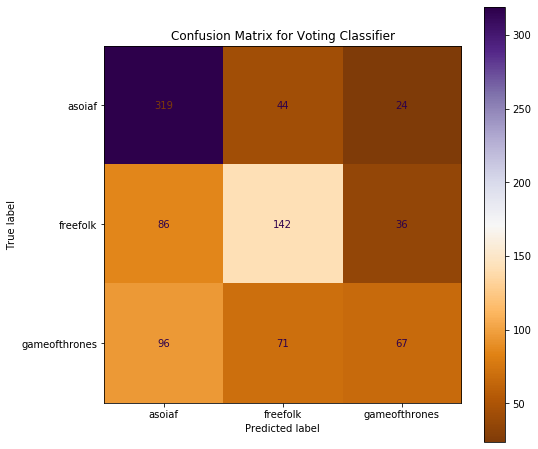

In [51]:
confusion_matrix(vc_pipe,'Voting Classifier')

Overall, our ensemble did not outperform our two best models (AdaBoost and the Decision Tree), on test set accuracy, likely due to the inclusion of too many poor/underfit models. That said, we did manage to mostly equalize the class bias of most of our models (a very consistent issue), with the exception of r/gameofthrones posts being identified as r/freefolk posts.

Given that after EDA, we evaluated it to be likely that r/asoiaf would be more readily distinguishable from the other two subreddits than r/freefolk and r/gameofthrones would be from each other, this is an expected result.

With additional experimentation, it's quite likely that we could isolate a more robust subset of input models for the final ensemble if we removed some of the particularly overfit ones. 

## Model Evaluation

We have already looked at each of our model performances individually, but it may be helpful to visualize their differences more 

In [52]:
model_accuracy.loc['BaselineModel','Train Accuracy'] = np.mean(baseline_train_preds == y_train)

model_accuracy.loc['BaselineModel','Test Accuracy'] = np.mean(baseline_test_preds == y_test)

model_accuracy.loc['BaselineModel','Overfittedness'] = np.mean(baseline_train_preds == y_train) - np.mean(baseline_test_preds == y_test)

In [53]:
model_accuracy

,Train Accuracy,Test Accuracy,Overfittedness,Best Params
LogisticRegression,1.000000,0.574011,0.426000,NaN
LassoLogisticRegression,1.000000,0.545763,0.454200,{'lasso__C': 1.0636067554253128}
RidgeLogisticRegression,1.000000,0.522034,0.478000,{'ridge__C': 6.009974959585542}
MultinomialNaiveBayes,0.753394,0.576271,0.177100,{'nb__alpha': 1.0166804751089014}
DecisionTree,0.663650,0.540113,0.123500,"{'dt__max_depth': 67.35017691080559, 'dt__min_..."
RandomForest,0.596154,0.536723,0.059400,"{'rf__max_depth': 31.42422429595377, 'rf__max_..."
Gradient Boost,0.436652,0.437288,-0.000600,"{'gb__learning_rate': 0.27620585618011995, 'gb..."
AdaBoost,0.689668,0.577401,0.112300,"{'ab__learning_rate': 0.0412459590679447, 'ab_..."
SupportVectorMachine,0.990573,0.552542,0.438000,"{'svc__C': 1.5580863867032468, 'svc__gamma': '..."
VotingClassifier,0.988688,0.596610,0.392100,NaN


#### Model Training Accuracy

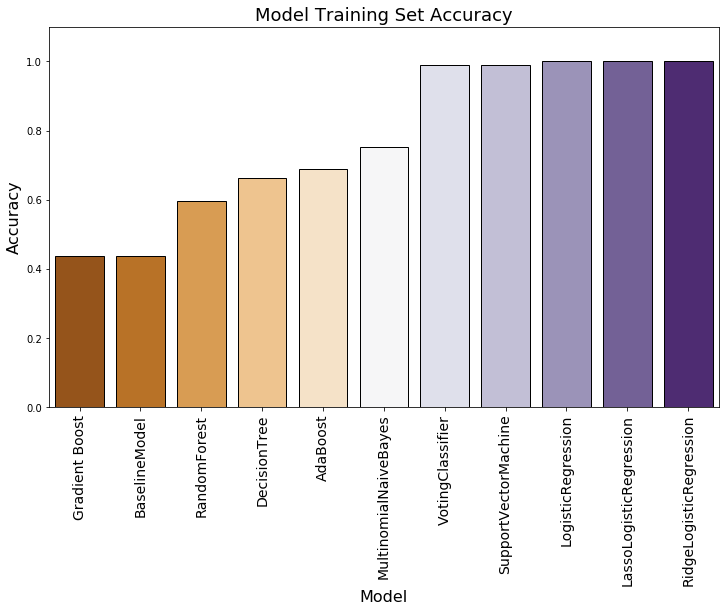

In [54]:
plt.figure(figsize=(12, 7))
sns.barplot(x=model_accuracy.sort_values('Train Accuracy').index,
            y=model_accuracy.sort_values('Train Accuracy')['Train Accuracy'],
            ec='k',
            linewidth=1,
            palette='PuOr'
            )
plt.xticks(rotation='vertical', fontsize=14)
plt.title('Model Training Set Accuracy', fontsize=18)
plt.ylim(0,1.1)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Model', fontsize=16);

As we saw during modeling, many of our models drastically overfit to the training data. This extremely low bias is undesireable, as it reflects a lack of generalizability. So, our best models are all on the "high bias" end of this spectrum, particularly the AdaBoost and Decision Tree.

#### Model Test Accuracy

In [108]:
model_accuracy

,Train Accuracy,Test Accuracy,Overfittedness,Best Params
LogisticRegression,1.000000,0.574011,0.426000,NaN
LassoLogisticRegression,1.000000,0.545763,0.454200,{'lasso__C': 1.0636067554253128}
RidgeLogisticRegression,1.000000,0.522034,0.478000,{'ridge__C': 6.009974959585542}
MultinomialNaiveBayes,0.753394,0.576271,0.177100,{'nb__alpha': 1.0166804751089014}
DecisionTree,0.663650,0.540113,0.123500,"{'dt__max_depth': 67.35017691080559, 'dt__min_..."
RandomForest,0.596154,0.536723,0.059400,"{'rf__max_depth': 31.42422429595377, 'rf__max_..."
Gradient Boost,0.436652,0.437288,-0.000600,"{'gb__learning_rate': 0.27620585618011995, 'gb..."
AdaBoost,0.689668,0.577401,0.112300,"{'ab__learning_rate': 0.0412459590679447, 'ab_..."
SupportVectorMachine,0.990573,0.552542,0.438000,"{'svc__C': 1.5580863867032468, 'svc__gamma': '..."
VotingClassifier,0.988688,0.596610,0.392100,NaN


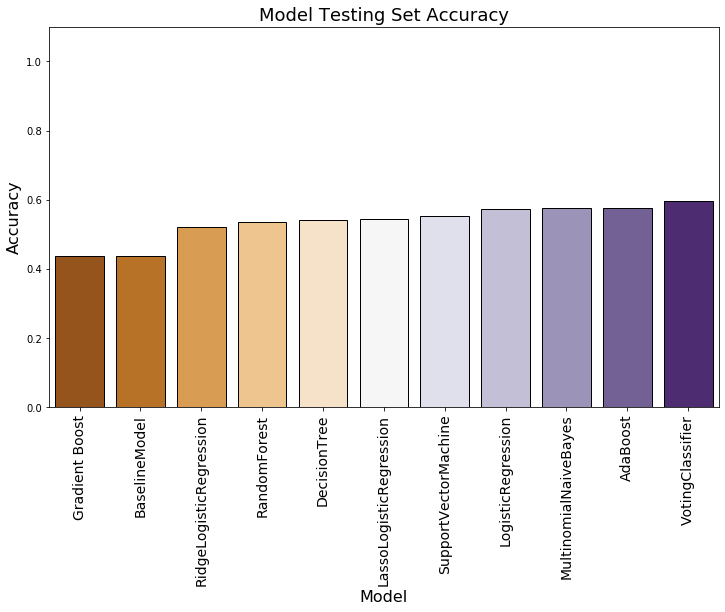

In [55]:
plt.figure(figsize=(12, 7))
sns.barplot(x=model_accuracy.sort_values('Test Accuracy').index,
            y=model_accuracy.sort_values('Test Accuracy')['Test Accuracy'],
            ec='k',
            linewidth=1,
            palette='PuOr'
            )
plt.xticks(rotation='vertical', fontsize=14)
plt.ylim(0,1.1)
plt.title('Model Testing Set Accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Model', fontsize=16);

This metric is our true target; how well can our models classify unseen data? While our unregularized and Lasso Logistic Regressions come close to the Ensemble, Decision Tree, and AdaBoost on training accuracy, their overfittedness will call their credibility into question:

#### Model Overfittedness

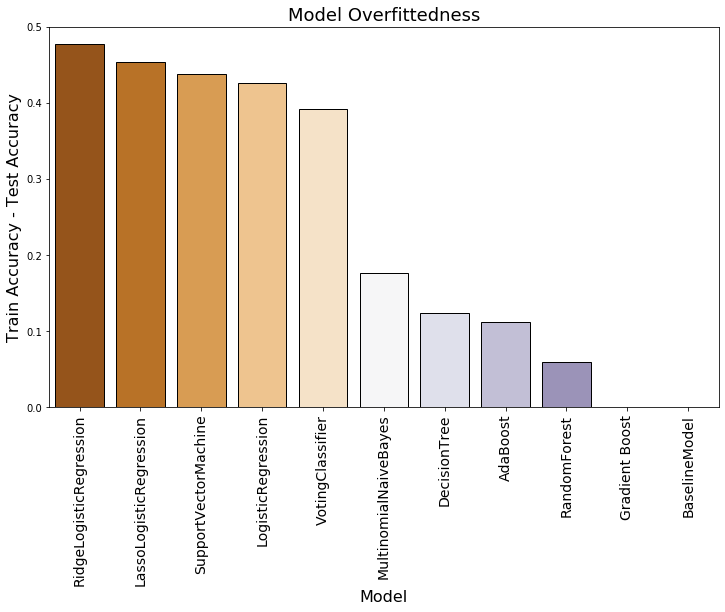

In [56]:
plt.figure(figsize=(12, 7))
sns.barplot(x=model_accuracy.sort_values('Overfittedness',ascending=False).index,
            y=model_accuracy.sort_values('Overfittedness',ascending=False)['Overfittedness'],
            ec='k',
            linewidth=1,
            palette='PuOr'
            )
plt.xticks(rotation='vertical', fontsize=14)
plt.title('Model Overfittedness', fontsize=18)
plt.ylim(0,.5)
plt.ylabel('Train Accuracy - Test Accuracy', fontsize=16)
plt.xlabel('Model', fontsize=16);

This chart is why we can feel confident with holding up AdaBoost and the Decision Tree as far-and-away our best models. While the Gradient Boosting Classifier was remarkably well-fit, it had an abysmal 24% Accuracy on train and test data, making it worthless. In its defense, had this been a binary classification problem, it might actually be our best model, but inverting its predictions doesn't work quite as well with a three-way classification.

It is likely that our ensemble model would be able to beat AdaBoost and the Decision Tree on more metrics if we didn't throw so many weak and overfit models into it, but that is a test for another time.

#### Decision Tree Analysis

In [57]:
dt_rs.best_estimator_.named_steps['dt']

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=67.35017691080559, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None,
                       min_samples_leaf=0.005061583846218687,
                       min_samples_split=0.16080805141749865,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

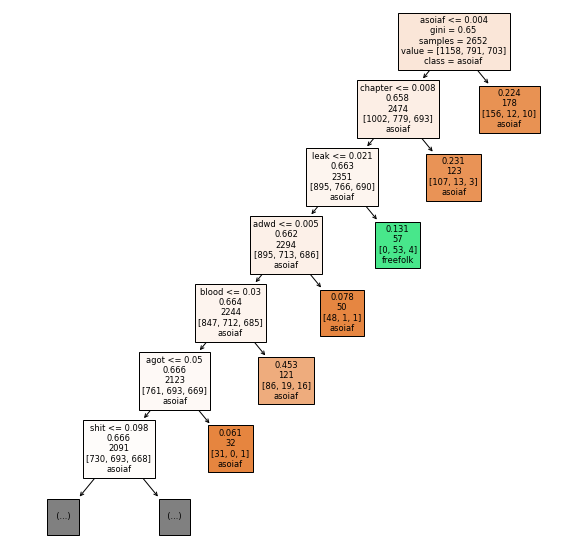

In [69]:
plt.figure(figsize=(10,10))
plot_tree(dt_rs.best_estimator_.named_steps['dt'],
          max_depth = 6, 
          feature_names=coef_names, 
          class_names=dt_rs.best_estimator_.classes_,
         filled=True,
         label='root');

#### Logistic Regression Coefficients

In [97]:
coef_dict = {}
for coef, feat in zip(logit_pipe.named_steps['logit'].coef_[0],coef_names):
    coef_dict[feat] = coef
asoiaf_coef = pd.DataFrame(coef_dict, index = coef_dict.keys())


### Bonus: fit on full dataset

Here we use the full dataset, instead of a 5% subset, to fit and predict with our best model, AdaBoost.

In [59]:
X = df['fulltext']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=42)

#### Fitting

In [60]:
ab_pipe = Pipeline([('tfid', TfidfVectorizer(
    max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
    stop_words=stop_words)),
    ('ab', AdaBoostClassifier())])

ab_params = {
    'tfid__max_df':uniform(.000001,1),
    'tfid__max_features':uniform(1000,10000),
    'tfid__min_df':uniform(.000001,1),
    'tfid__ngram_range':[(1,1),(1,2),(1,3)],
    'tfid__stop_words':[stop_words],
    'ab__n_estimators': np.linspace(10,1000,10),
    'ab__learning_rate': loguniform(.00001, 50)
}

In [61]:
ab_rs = RandomizedSearchCV(ab_pipe,
                             ab_params,
                             n_iter=10000,
                             cv=5,
                             n_jobs=-1,
                             verbose=True,
                             random_state = 42)

ab_rs.fit(X_train,y_train)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 73.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 118.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 165.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 225.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 297.3min


KeyboardInterrupt: 

#### Evaluation

In [ ]:
add_accuracy(ab_rs,'AdaBoost')
model_accuracy

In [ ]:
confusion_matrix(ab_rs.best_estimator_,'AdaBoost')